In [49]:
!pip install datasets transformers==4.28.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Import Libraries

In [50]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from textblob import TextBlob

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#transformers
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)



nltk.download('punkt')


from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/tmp/ipykernel_28/3309095161.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 2.4 GB
Cached:    4.0 GB


# Load Data

In [52]:
import pandas as pd
data = pd.read_csv('/kaggle/input/brad-book-review/BRAD.tsv' , delimiter='\t' , header=None)

In [53]:
data = data.drop(data.columns[1], axis=1)
data = data.drop(data.columns[1], axis=1)
data = data.drop(data.columns[1], axis=1)

In [54]:
data.head(2)

,0,4
0,4,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...


In [55]:
data = data.rename(columns={0:"label" , 4:"review"})

In [56]:
data.head(2)

,label,review
0,4,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...


In [57]:
data.label.value_counts()

5    166972
4    158462
3    106785
2     47133
1     31247
Name: label, dtype: int64

# Count diacritaical marks

In [58]:
def count_diacritical_marks(texts):
    total = 0
    # use a regular expression to match the diacritical marks
    for text in texts:
        diacritical_marks = re.findall(r'[\u064B-\u065F]', text)
        # count the number of matches
        count = len(diacritical_marks)
        total = total + count
    return total

In [59]:
count =count_diacritical_marks(data['review']) 

In [60]:
print("Number of diacritical marks is " + str(count))

Number of diacritical marks is 1345161


In [61]:
def mark_sentiment(rating):
    # Subjective (Neutral)
    if(rating==3):
        return 1
    # Objective (Positive and Neagitve)
    else:
        return 0

In [62]:
data.label.value_counts()

5    166972
4    158462
3    106785
2     47133
1     31247
Name: label, dtype: int64

In [63]:
data['label'] = data['label'].apply(lambda x:mark_sentiment(x))

In [64]:
data.head()

,label,review
0,0,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,0,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,0,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,0,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
4,1,هذا الكتاب يحزن مرا، ظلم واضطهاد عيسى بلا ذنب ...


In [65]:
stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","كان","ّأيّان"}

st = ISRIStemmer()
def stemNLTK(text):
    # tokenize
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ty = st.stem(w)
        cleaned.append(ty)
    return " ".join(cleaned)


def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)


def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in stops and not w in stop_word_comp and len(w) >= 2])



def clean_text(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    ## Convert text to lowercases
    text = text.lower()
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    #text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    #Stemming
    text = stemNLTK(text)
    return text

In [66]:
data['review'] = data['review'].apply(lambda x:clean_text(x))

In [67]:
data.head()

,label,review
0,0,صرع جذر نمء عقل ساق خيز وئم نفس نمو ايا ترب فك...
1,0,كتب رئع عقد ريه كله لخص جمل وحد عطء حب قيم
2,0,روي لمس روح عمق فخر اني اخر لقت روي عرب كتب به...
3,0,روي حكم بكل خصر جزء فضل نسب وصف كتب حية عيسى ف...
4,1,كتب يحز مرا ظلم ضطهاد عيسى بلا ذنب فصل كتب خلف...


In [68]:
data['review'].duplicated().sum()

13773

In [69]:
data.drop_duplicates("review", inplace=True)

In [70]:
data.label.value_counts()

0    392012
1    104814
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

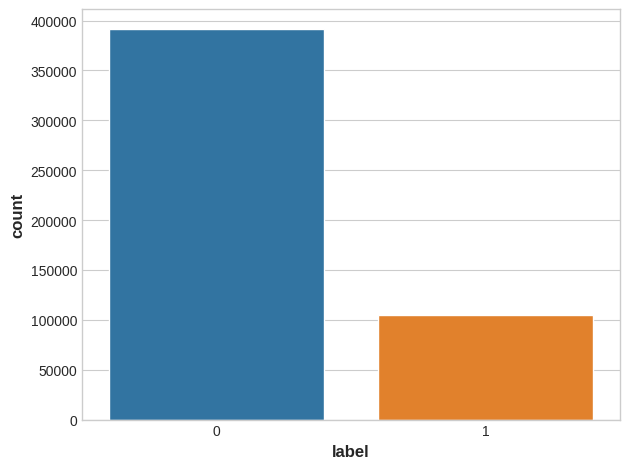

In [71]:
sns.countplot(x=data["label"])

In [72]:
datasetNeg , datasetPos, = (g for _,g in data.groupby('label'))

In [73]:
print(datasetNeg.shape)
datasetNeg.head()

(392012, 2)


,label,review
0,0,صرع جذر نمء عقل ساق خيز وئم نفس نمو ايا ترب فك...
1,0,كتب رئع عقد ريه كله لخص جمل وحد عطء حب قيم
2,0,روي لمس روح عمق فخر اني اخر لقت روي عرب كتب به...
3,0,روي حكم بكل خصر جزء فضل نسب وصف كتب حية عيسى ف...
5,0,روي وقع ورع مثل حدث كرر جمع خلج وأن أثر لأن عش...


In [74]:
print(datasetPos.shape)
datasetPos.head()

(104814, 2)


,label,review
4,1,كتب يحز مرا ظلم ضطهاد عيسى بلا ذنب فصل كتب خلف...
10,1,يخل عبث انك ساق مبو قدر ضرب جذر عمق ترب حدث صد...
23,1,لمذ روي نسب الي كبق روي قرأ تحر لدي شعر نحو عك...
30,1,روي رئع جمل
38,1,حبب روي مثل ورب قرأ ارا تيف حبب


In [75]:
datasetNeg = datasetNeg.iloc[0 :80000 ]
datasetPos = datasetPos.iloc[0 :70000 ]

In [76]:
data = pd.concat([datasetPos,datasetNeg])

In [77]:
print(data.shape)
data.head()

(150000, 2)


,label,review
4,1,كتب يحز مرا ظلم ضطهاد عيسى بلا ذنب فصل كتب خلف...
10,1,يخل عبث انك ساق مبو قدر ضرب جذر عمق ترب حدث صد...
23,1,لمذ روي نسب الي كبق روي قرأ تحر لدي شعر نحو عك...
30,1,روي رئع جمل
38,1,حبب روي مثل ورب قرأ ارا تيف حبب


In [78]:
data.label.value_counts()

0    80000
1    70000
Name: label, dtype: int64

In [79]:
text_len = []
for text in data.review:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
    
data['text_len'] = text_len

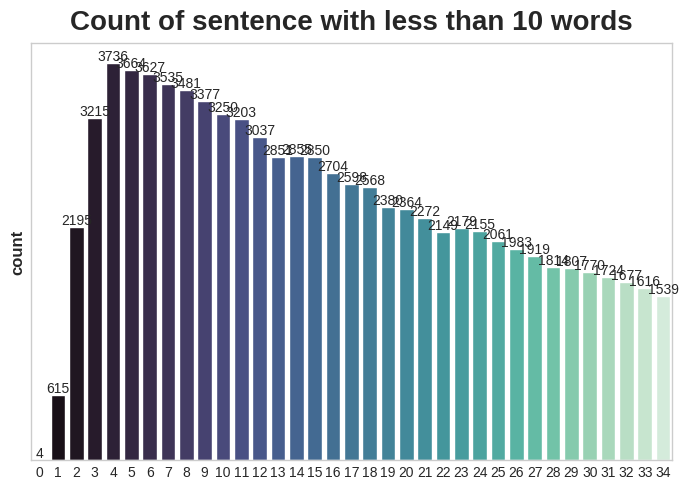

In [80]:
plt.figure(figsize=(7,5))

ax = sns.countplot(x='text_len', data=data[data['text_len'] < 35 ], palette='mako')
plt.title('Count of sentence with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [81]:
data.sort_values(by=['text_len'], ascending=False)

,label,review,text_len
58007,0,جرم فعل جمع صدقاء عصم وسف جمل روي الل قرت بجد ...,1204
68389,0,ولد حرت ارخ بشر خلق قدم بدي انا كنت سمع قصة دى...,1172
98277,1,وضح هام وضح هام ريفيو ضفت نقش فيد بشد عمل ؤلف ...,1091
68398,0,علق كتب فرع الف دين علم علق ام بنئ هى اصل وهم ...,1083
42967,0,بدى تقر كتب تحس انك حصة ارخ درس بيخ شنب كبر وط...,1069
...,...,...,...
8765,0,سبب,1
275184,1,,0
5324,0,,0
349518,1,,0


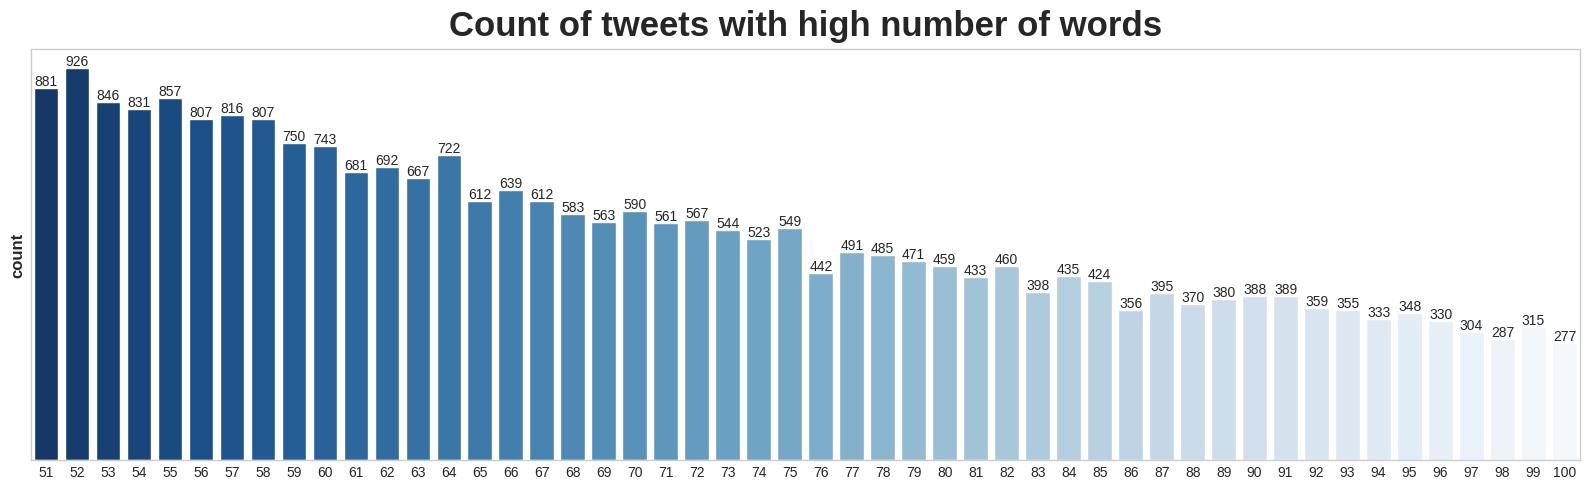

In [82]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=data[(data['text_len']<=100) & (data['text_len']>50)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [83]:
data = data[data['text_len'] <= 100]
data = data[data['text_len'] > 1]

In [84]:
max_len = np.max(data['text_len'])
max_len 

100

In [85]:
data.label.value_counts()

0    69629
1    60844
Name: label, dtype: int64

In [86]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')


def acc(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    preds_flat = preds_flat.tolist()
    labels_flat = labels.flatten()
    labels_flat = labels_flat.tolist()
    y = labels_flat
    yHat = preds_flat
    truee = 0
    for i in range(len(y)):
        if(y[i] == yHat[i]):
            truee += 1
    return (truee / len(y))

def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [87]:
(unique, counts) = np.unique(data['label'], return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 69629],
       [    1, 60844]])

In [88]:
from sklearn.model_selection import train_test_split

Extra_Len = 6 # an extra padding in length , found to be useful for increasing F-score

#Spliting the Training data
Rand_Seed = 42 


# assume you have your data and labels stored in X and y variables
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
train_set, evaluation_set = train_test_split(train_set, test_size=0.08, random_state=42)

Max_Len = train_set['review'].str.split().str.len().max() + Extra_Len
print(Max_Len)

print("Train set: ")
print(train_set['label'].value_counts())
print("---------------------------")
print ("Evaluation set: ")
print (evaluation_set['label'].value_counts())

106
Train set: 
0    51371
1    44656
Name: label, dtype: int64
---------------------------
Evaluation set: 
0    4451
1    3900
Name: label, dtype: int64


In [89]:
Model_Used = "UBC-NLP/MARBERT"
Task_Name = "classification"

class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list
        
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(BERTModelDataset).__init__()
        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map
  
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
    
        encoded_review = self.tokenizer.encode_plus(
        text,
        max_length= self.max_len,
        add_special_tokens= True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        truncation='longest_first',
        return_attention_mask=True,
        return_tensors='pt'
        )
        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)
        return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

In [90]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map))

def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))

    macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[1,2])
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
        'macro_f1' : macro_f1,
        'macro_f1_pos_neg' : macro_f1_pos_neg,  
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': acc
    }

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [91]:
label_list = list(train_set['label'].unique())

print(label_list)
print(train_set['label'].value_counts())

data_set = Dataset( "BRAD", train_set, evaluation_set, label_list )

label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

train_dataset = BERTModelDataset(train_set['review'].to_list(),
                                 train_set['label'].to_list(),Model_Used,Max_Len,label_map)

evaluation_dataset = BERTModelDataset(evaluation_set['review'].to_list(),
                                      evaluation_set['label'].to_list(),Model_Used,Max_Len,label_map)

test_dataset = BERTModelDataset(train_set['review'].to_list(),
                                      train_set['label'].to_list(),Model_Used,Max_Len,label_map)

[1, 0]
0    51371
1    44656
Name: label, dtype: int64
{1: 0, 0: 1}


In [92]:
print(test_dataset[0])

InputFeatures(input_ids=tensor([    2,  7200,  7200,  7831,  2276,  1018, 14958,  8282,  6325, 14958,
         4112,  7200,  2105,  7831,  2276,  1018,  3733,  2014,  3151,  5342,
         7792,  1046,  2562,  6637,  1998, 27536,  2119, 13046,  2835,  3670,
         1024,  2554,  3790,  5685,  8548,  4053,  1025,  7325, 43003, 35014,
        66956,  2441, 66381, 17760, 23452,  8670, 17255,  3475,  1025,  2831,
        29140,  3757,  1010,  3012,  3873,  2119, 11351, 14348, 49148, 11239,
        12556,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0], device='cuda:0'), attention_mask=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [93]:
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-9 
training_args.fp16 = True
training_args.per_device_train_batch_size = 12 #64 
training_args.per_device_eval_batch_size = 12 # 64 
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 4
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.logging_steps = 200
training_args.save_steps = 100000 
training_args.seed = 42 
training_args.disable_tqdm = False

In [94]:
import os
training_args.dataloader_pin_memory = False
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

model1 = model_init()

trainer = Trainer(
    model = model1,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset= evaluation_dataset,
    compute_metrics=compute_metrics
)

print(training_args.seed)

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

42


In [95]:
print(Max_Len)
print(training_args.learning_rate)
print(training_args.adam_epsilon)
print(training_args.warmup_steps)
#wandbkey if needed (depend on the transformers package version) = 0a58b374c46a154de1ba77c8634c6be279a9dcdb
trainer.train()

106
5e-05
1e-09
0


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy
1,0.585300,0.585664,0.702771,0.350193,0.706888,0.706395,0.702790
2,0.501300,0.553489,0.724011,0.379439,0.730283,0.723229,0.728416
3,0.414800,0.603659,0.719660,0.374349,0.722444,0.718964,0.722668
4,0.333000,0.677508,0.708968,0.365688,0.709412,0.708698,0.710693


              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3900
           1       0.76      0.65      0.70      4451

    accuracy                           0.70      8351
   macro avg       0.71      0.71      0.70      8351
weighted avg       0.71      0.70      0.70      8351



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      3900
           1       0.72      0.80      0.76      4451

    accuracy                           0.73      8351
   macro avg       0.73      0.72      0.72      8351
weighted avg       0.73      0.73      0.73      8351



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      3900
           1       0.72      0.78      0.75      4451

    accuracy                           0.72      8351
   macro avg       0.72      0.72      0.72      8351
weighted avg       0.72      0.72      0.72      8351



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      3900
           1       0.72      0.74      0.73      4451

    accuracy                           0.71      8351
   macro avg       0.71      0.71      0.71      8351
weighted avg       0.71      0.71      0.71      8351



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TrainOutput(global_step=8004, training_loss=0.4618862037775458, metrics={'train_runtime': 4310.0672, 'train_samples_per_second': 89.119, 'train_steps_per_second': 1.857, 'total_flos': 2.092321189987344e+16, 'train_loss': 0.4618862037775458, 'epoch': 4.0})

In [96]:
trainer.evaluate(test_dataset)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

           0       0.89      0.87      0.88     44656
           1       0.89      0.91      0.90     51371

    accuracy                           0.89     96027
   macro avg       0.89      0.89      0.89     96027
weighted avg       0.89      0.89      0.89     96027



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.28054407238960266,
 'eval_macro_f1': 0.8901185990555802,
 'eval_macro_f1_pos_neg': 0.44942356856881,
 'eval_macro_precision': 0.8907936834207058,
 'eval_macro_recall': 0.8896072833653635,
 'eval_accuracy': 0.8908119591364929,
 'eval_runtime': 409.0105,
 'eval_samples_per_second': 234.779,
 'eval_steps_per_second': 9.785,
 'epoch': 4.0}

In [97]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")


In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def predict(text):
    text = clean_text(text)
    encoded_review = tokenizer.encode_plus(text, max_length=Max_Len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True, #True,
    truncation='longest_first',
    return_attention_mask=True,
    return_tensors='pt'
    )
    input_ids = encoded_review['input_ids'].to(device) #(input_ids + ([tokenizer.pad_token_id] * padding_length)).to(device)  
    attention_mask = encoded_review['attention_mask'].to(device)
    
    output = model1(input_ids, attention_mask)
    _, prediction = torch.max(output[0], dim=1)
    return prediction[0].cpu().detach().numpy()

In [99]:
print(predict("االكورس شكله جميل"))

0


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [100]:
torch.save(model1, "Arabic_Subjecitive_Objective.pt")